In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee'])

In [2]:
dataset = ds.dataset("sig_data/merged.parquet", format="parquet")

In [3]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'N_KL', 'idec0',
       'idec1', 'totalEnergyMC', 'E_gamma_in_ROE', 'Bs_lik', 'is0',
       'Miss_id_0', 'Miss_id_1', 'missedE', 'M0', 'p0', 'recM2', 'p_tau_0',
       'p_tau_1', 'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'correct_nu_0', 'correct_nu_1',
       'correct_gamma_0', 'correct_gamma_1', 'lost_0', 'lost_1',
       'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0', 'PID_self_vs_2_tau0',
       'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1', 'PID_self_vs_1_tau1',
       'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [4]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))

In [5]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_19124\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [6]:
wbin = 0.2
a = 0
b = 5
bins = np.linspace(a, b, int((b-a)/wbin))

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\1180932936.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


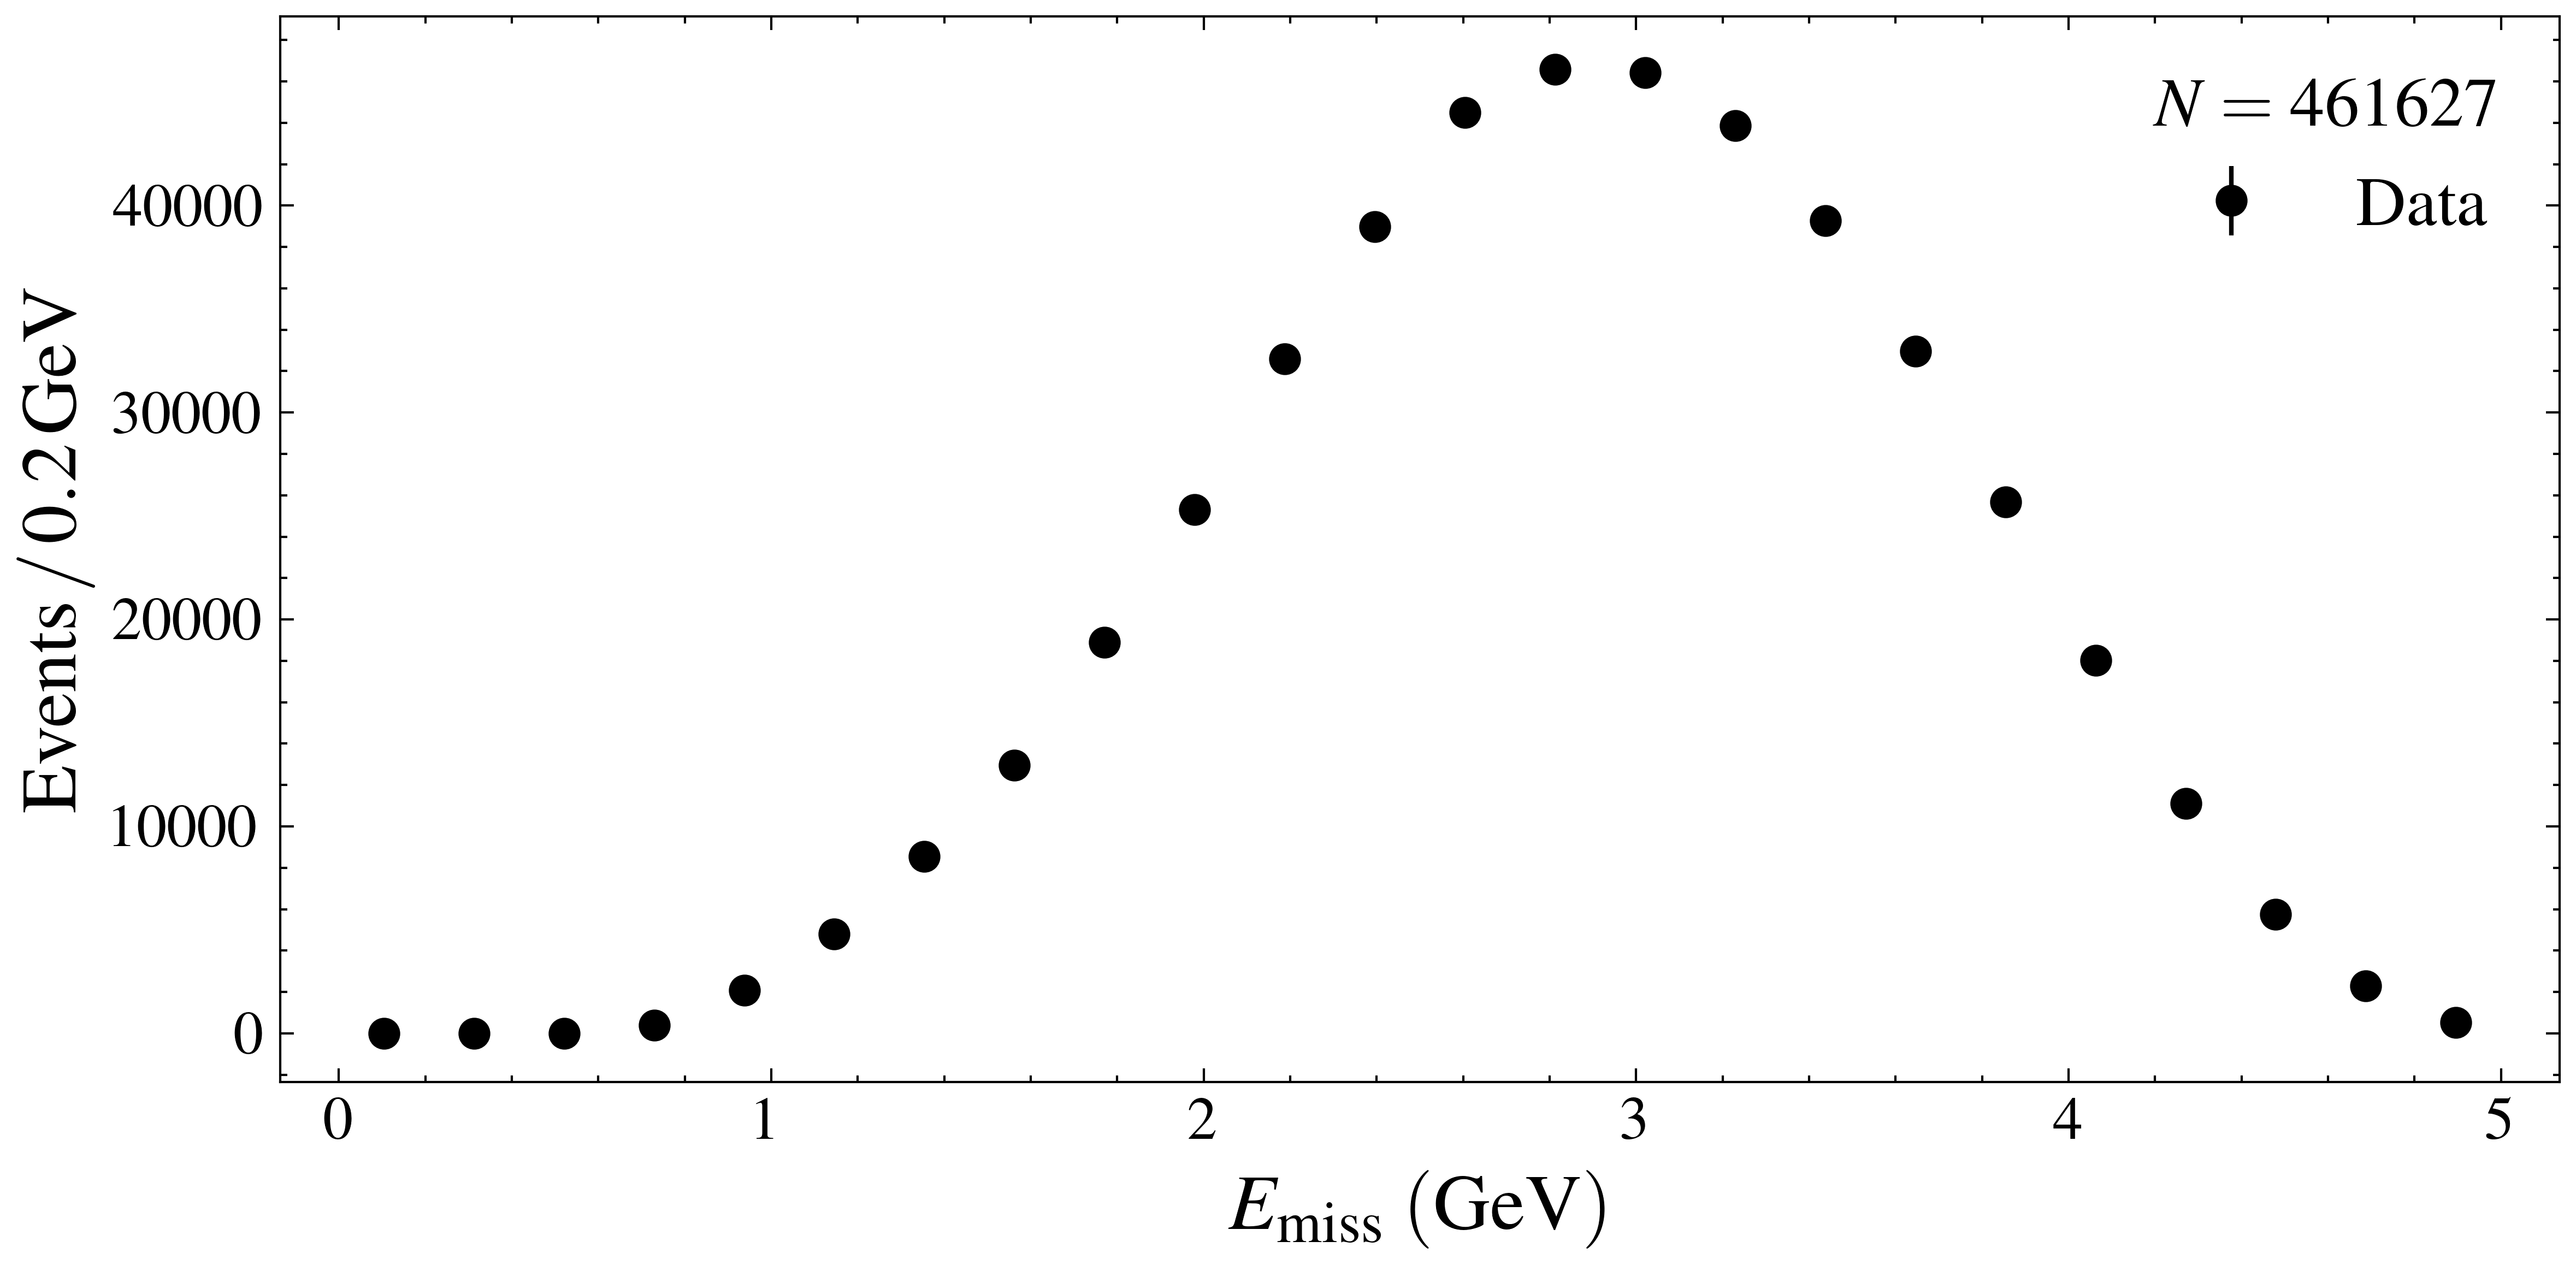

In [7]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask=mask_is1 & mask)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")


plt.tight_layout()
plt.show()

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\3263174918.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


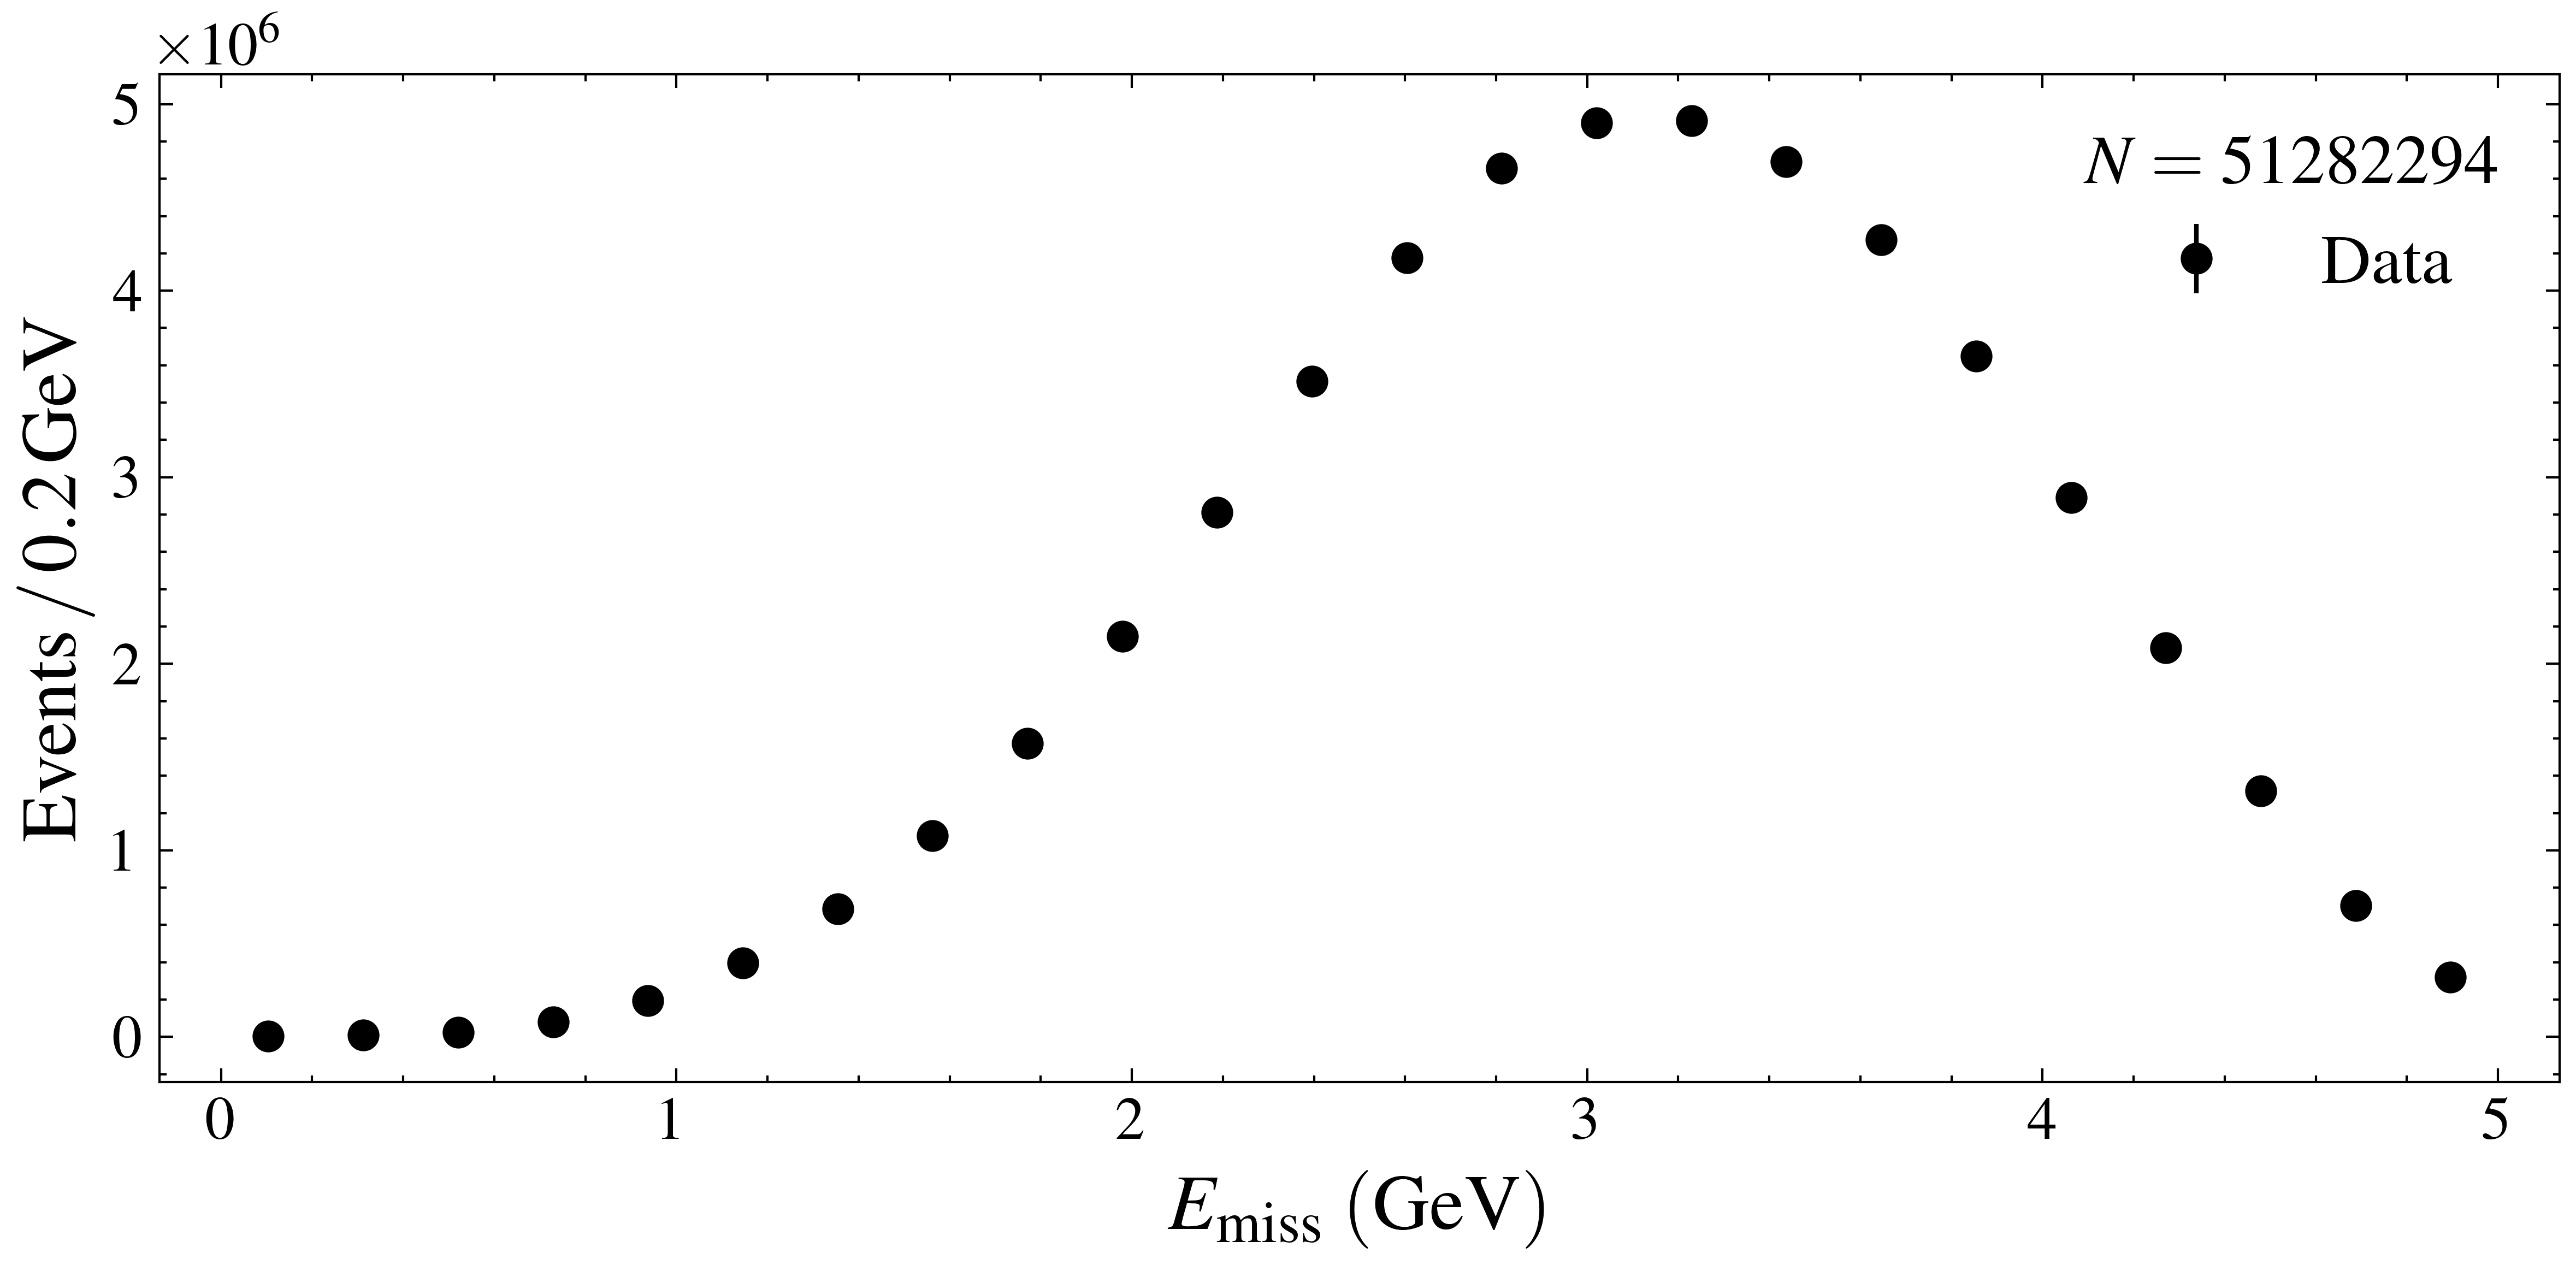

In [8]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask=mask_is0  & mask)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\4216748683.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


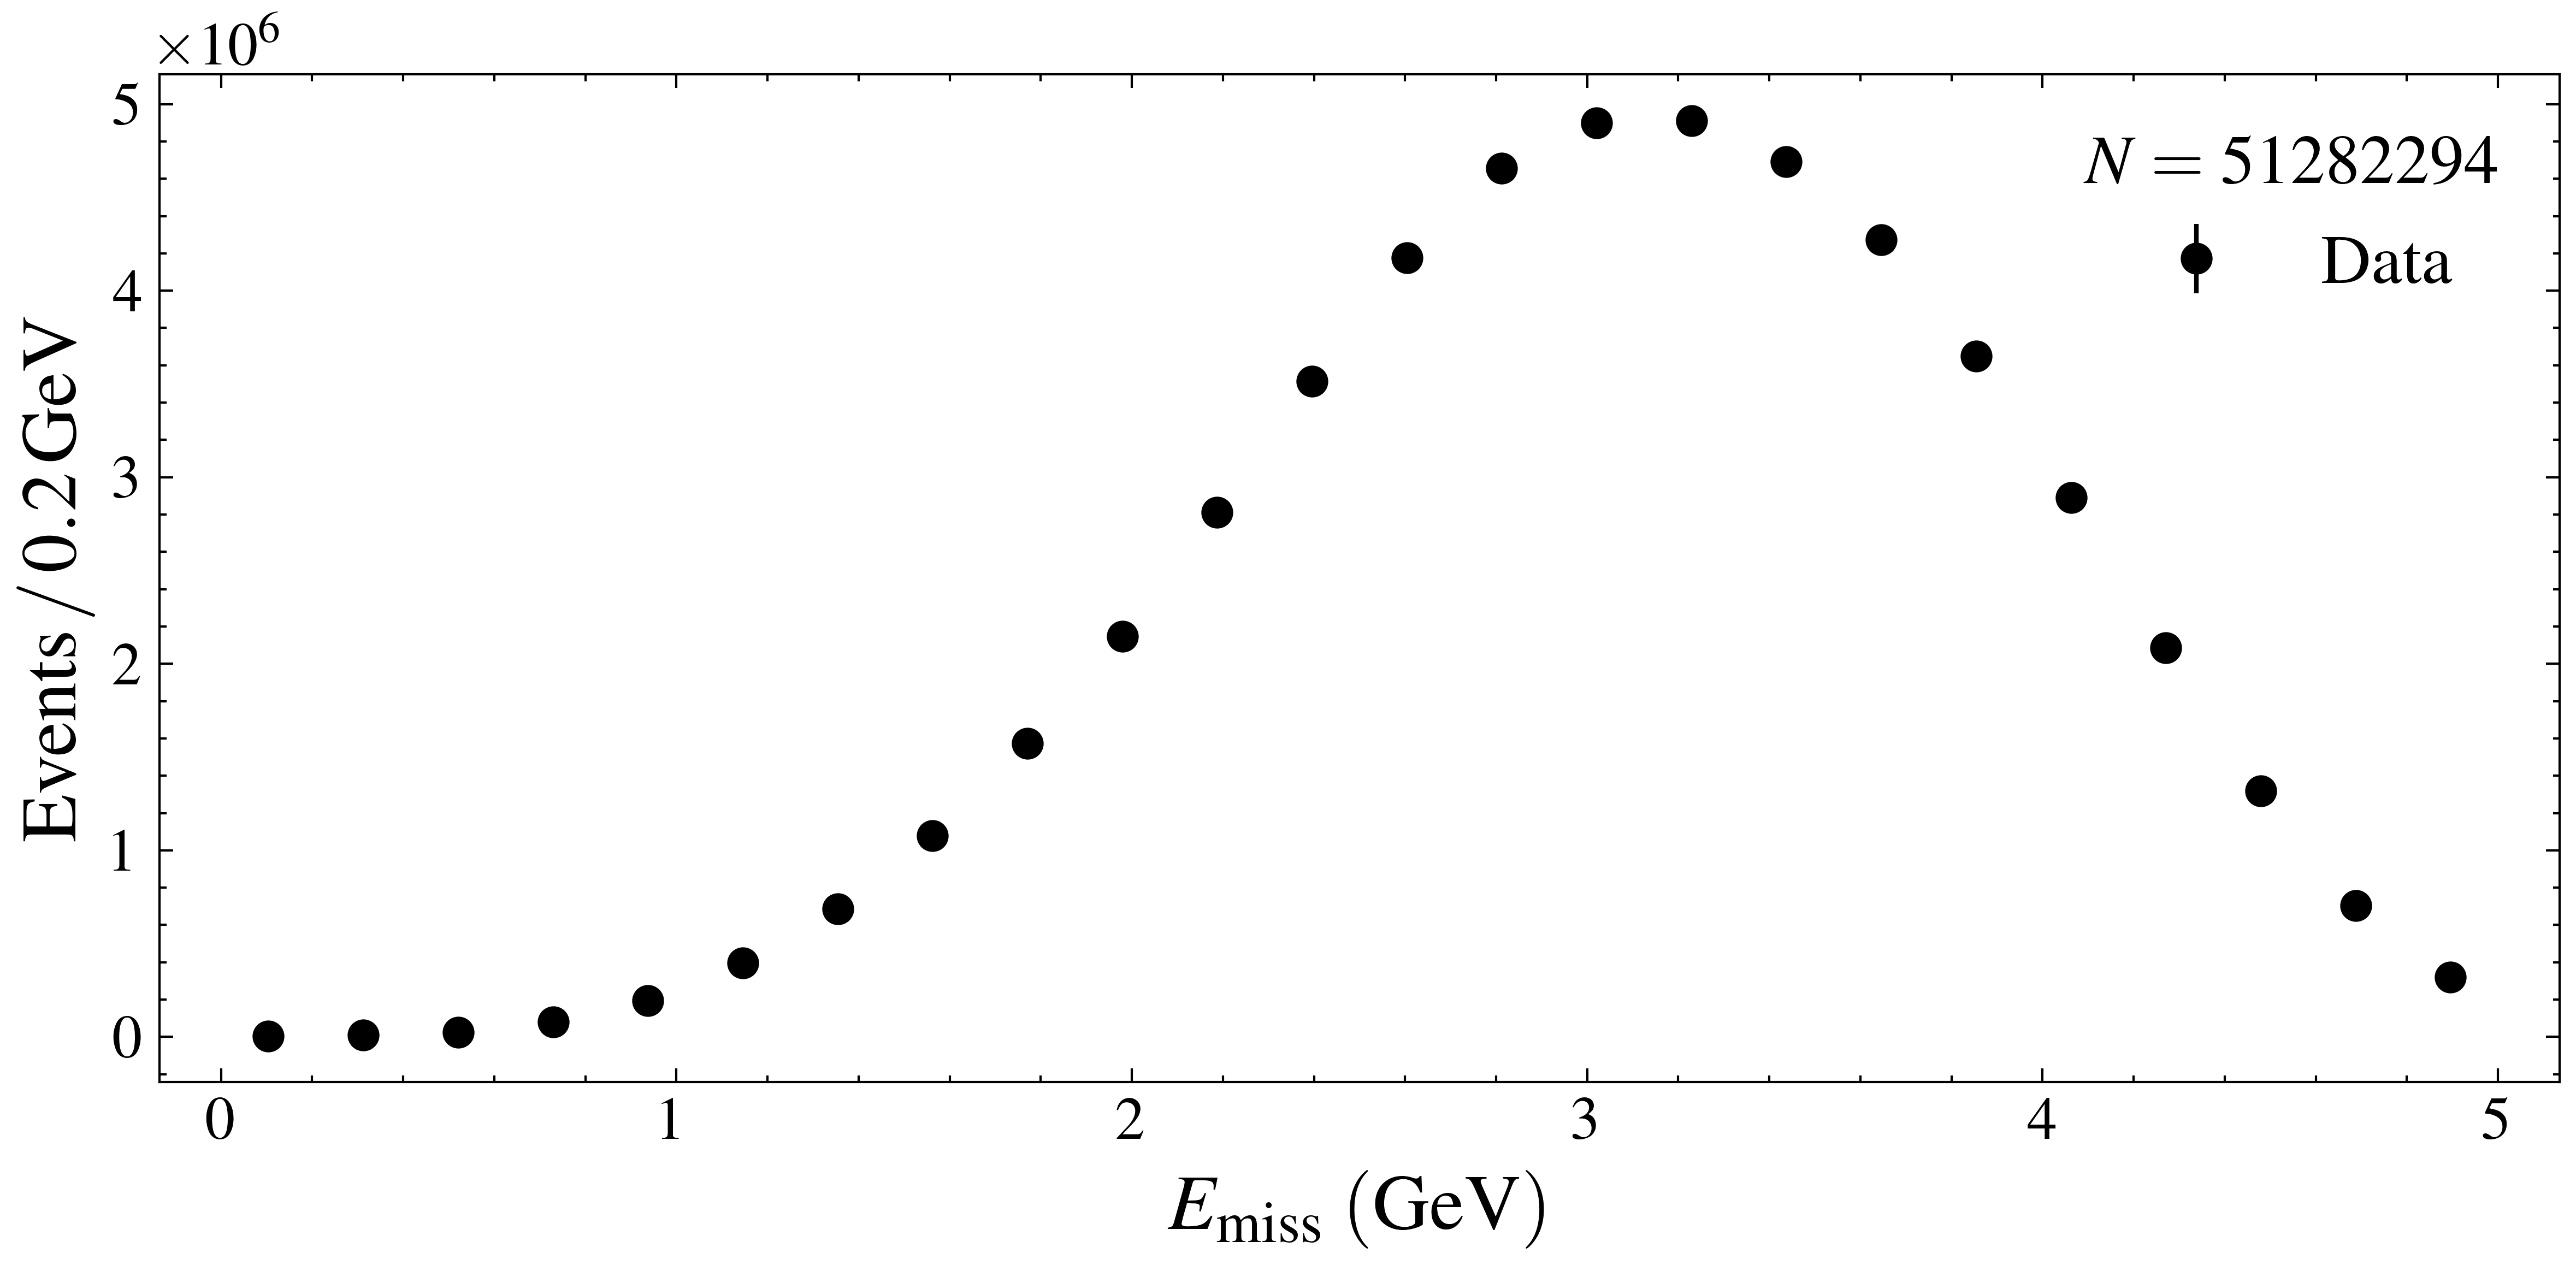

In [9]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask= mask)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [10]:
wbin = 0.2
a = 0
b = 10
bins = np.linspace(a, b, int((b-a)/wbin))

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\3075491157.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


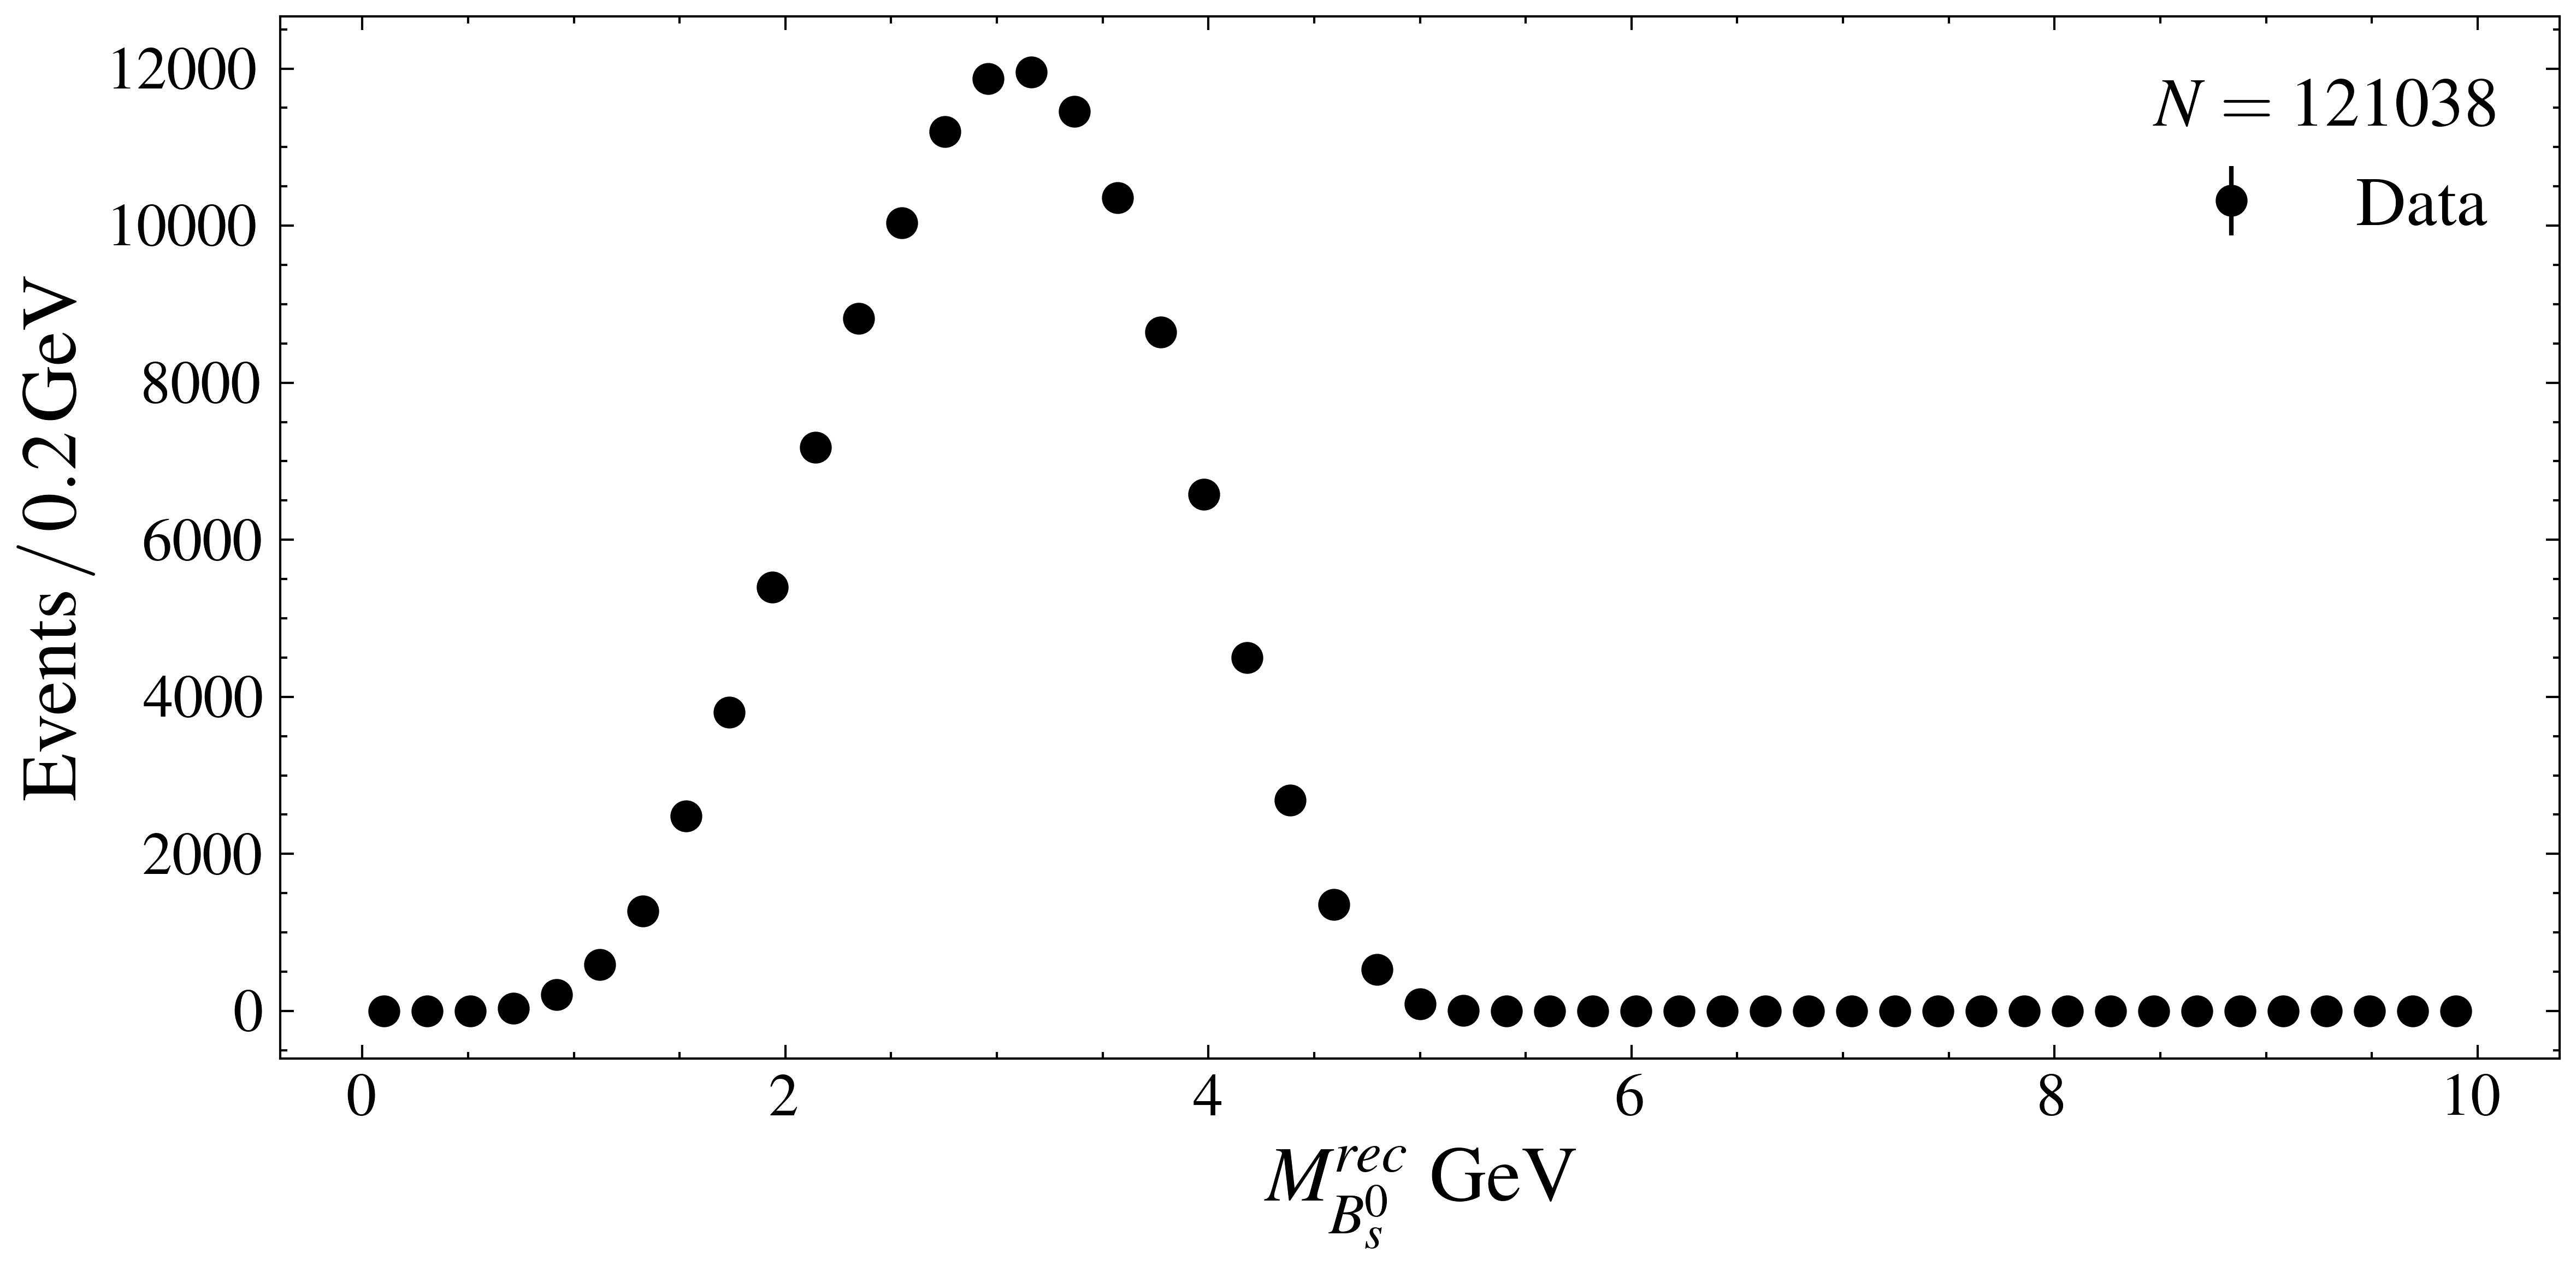

In [11]:
bin_centers, counts, N = compute_histogram(dataset, bins, "recM2", fun=lambda x: np.sqrt(x), filter_mask= mask & mask_is0 & mask_is1 & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$M^{rec}_{B_s^0} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [12]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

In [43]:
def max_bin_lik(f, bin_centers, counts, args0, bounds=None, err_need = False):
    normalization = np.max(counts)//100
    counts = counts/normalization
    norm = np.sum(counts)
    args0["norm"] = norm

    pdf = lambda x, args: f(x, **{k: v for k, v in args.items() if k != "norm"}) * args["norm"]

    if bounds != None:
        bounds["norm"] = (0, norm*100)
    def df(*args):
        current_args = {k: v for k, v in zip(args0.keys(), args)}
        return -np.sum(np.log(puasson(pdf(bin_centers, *current_args), counts)))
    
    minuit = Minuit(df, *[args0[__key] for __key in args0.keys()], name=args0.keys())
    minuit.migrad()
    rez = minuit.values
    norm = rez[0]*normalization
    print(rez)
    if err_need:
        return rez, pdf, norm, minuit.errors
    return rez, pdf


In [ ]:
def max_bin_lik(f, bin_centers, counts, args0, constraints = None):
    pdf = lambda x, A, *args: A*f(x, *args) 
    args0 = 1, *args0
    weights = 1 / (counts + 1e-5)
    if constraints == None:
        df = lambda *args0: np.sum((pdf(bin_centers, *args0) - counts)**2)
    else:
        df = lambda *args0: np.sum(1 + np.sum([np.abs(con(args0[1:])) for con in constraints]))*np.sum(np.abs((pdf(bin_centers, *args0) - counts)*weights)**2)
    minuit = Minuit(df, *args0)
    minuit.migrad()
    rez = minuit.values
    minuit = Minuit(df, *rez)
    minuit.migrad()
    rez = minuit.values
    return rez[1:], rez[0]

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\997772634.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


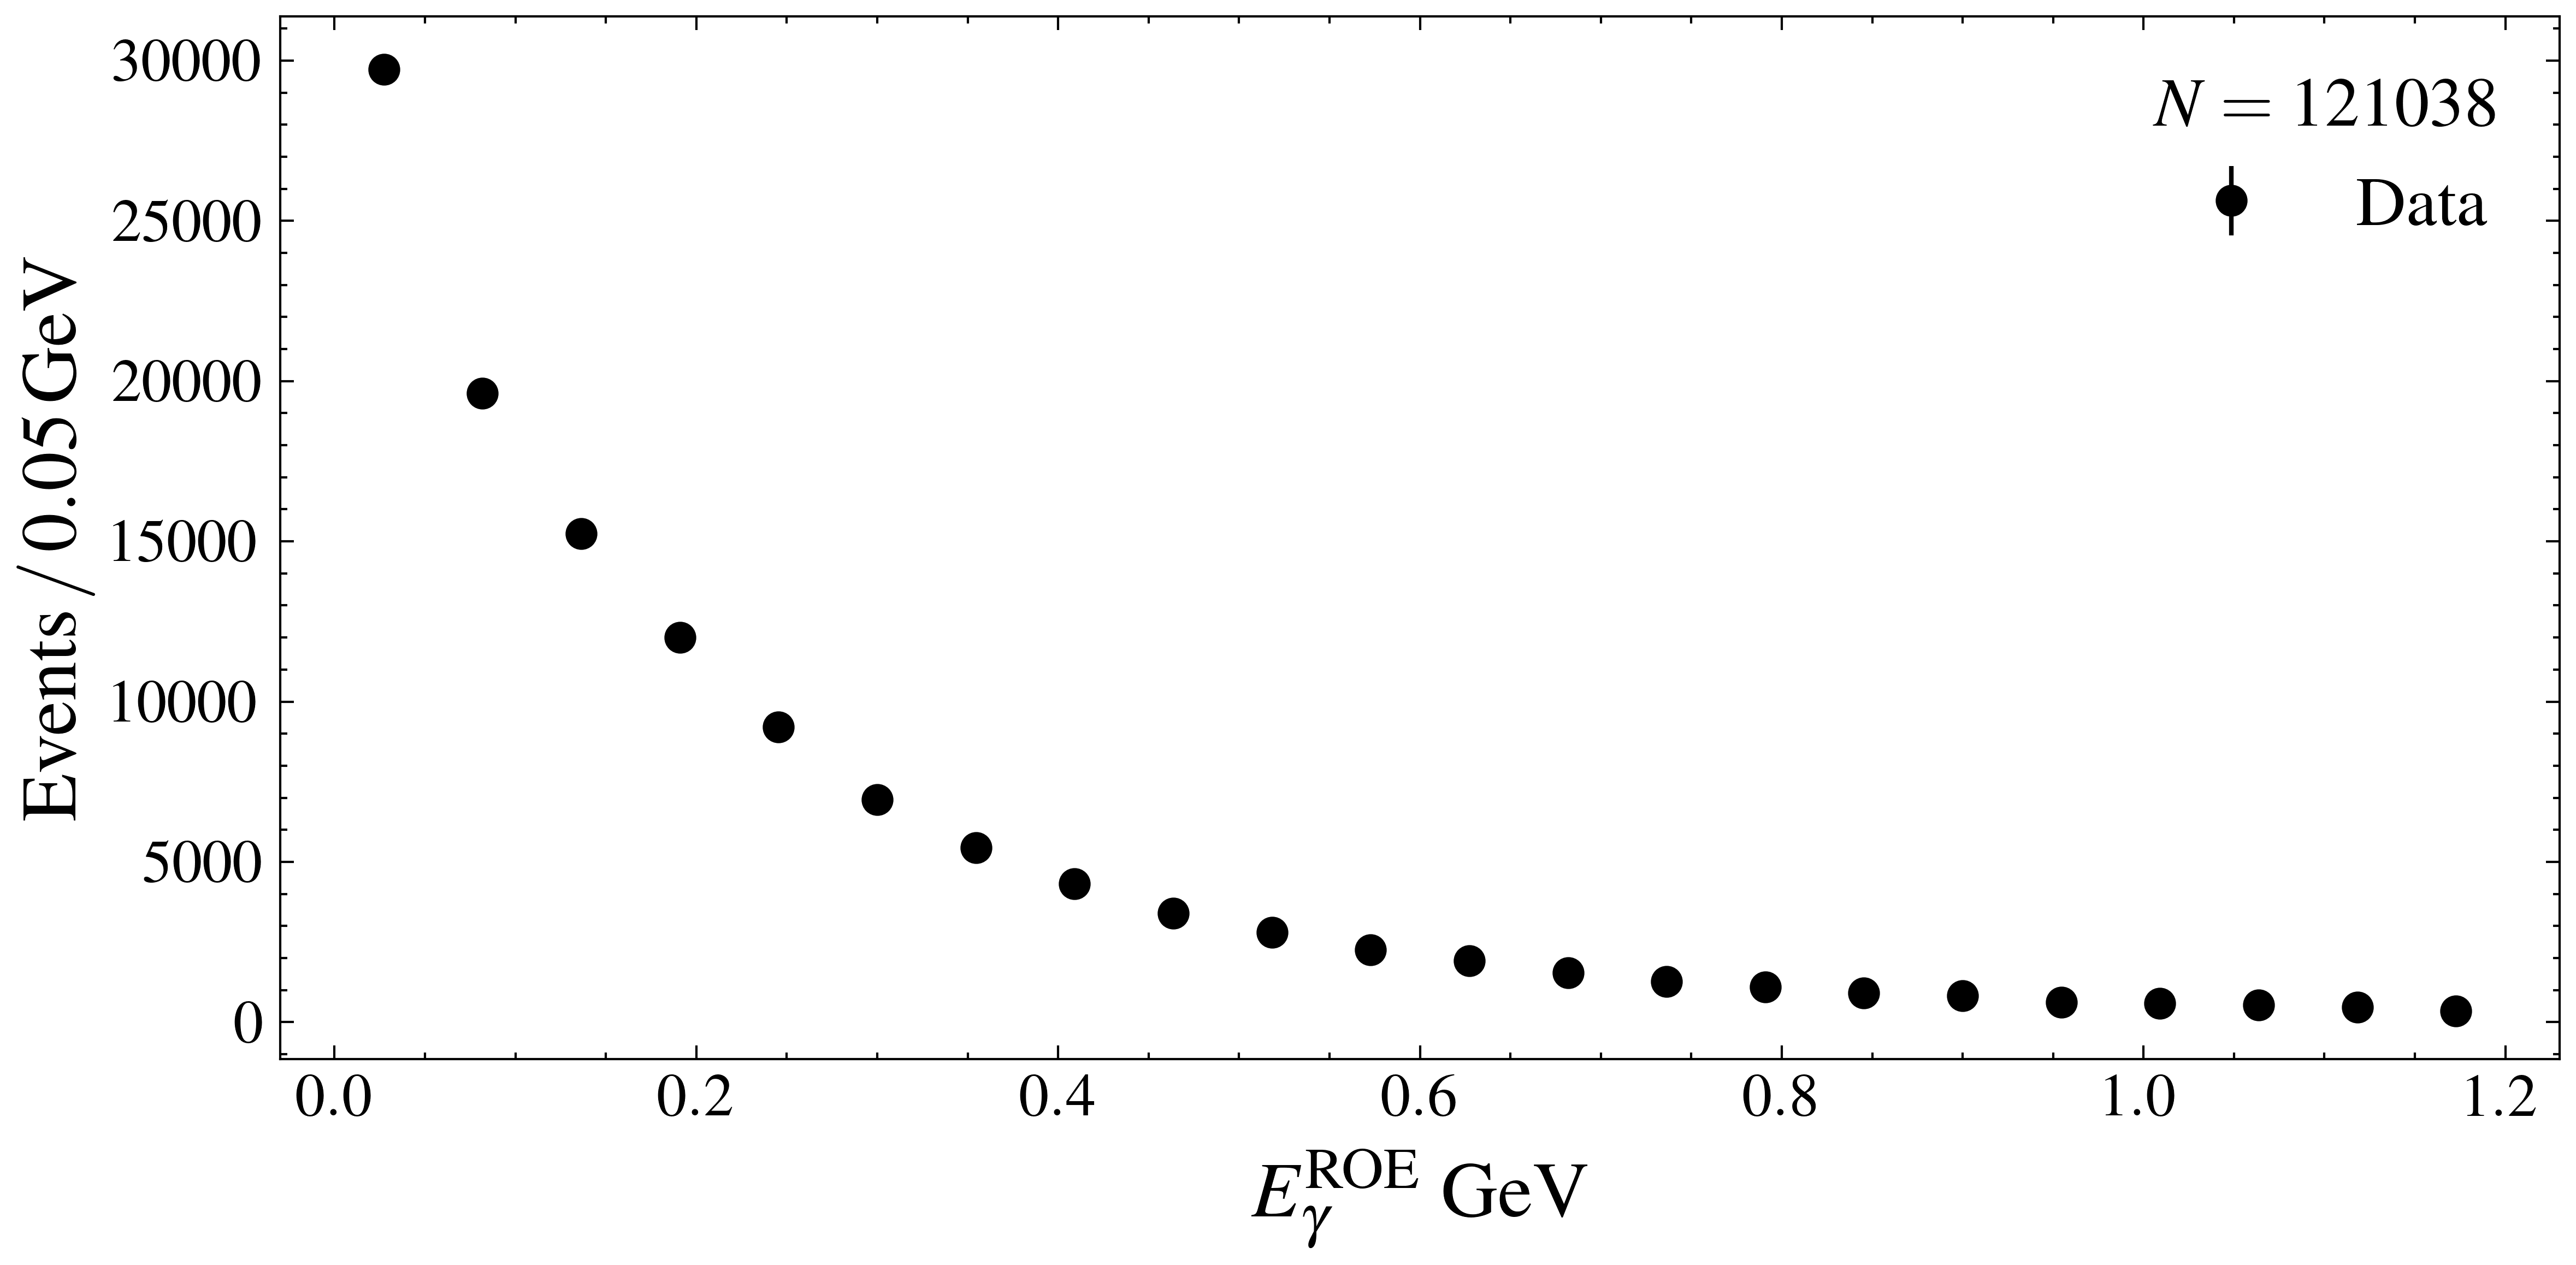

In [13]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_is0 & mask_is1 & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [16]:
wbin = 0.003
a = 0
b = 0.2
bins = np.linspace(a, b, int((b-a)/wbin))

C:\Users\matve\AppData\Local\Temp\ipykernel_19124\997772634.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


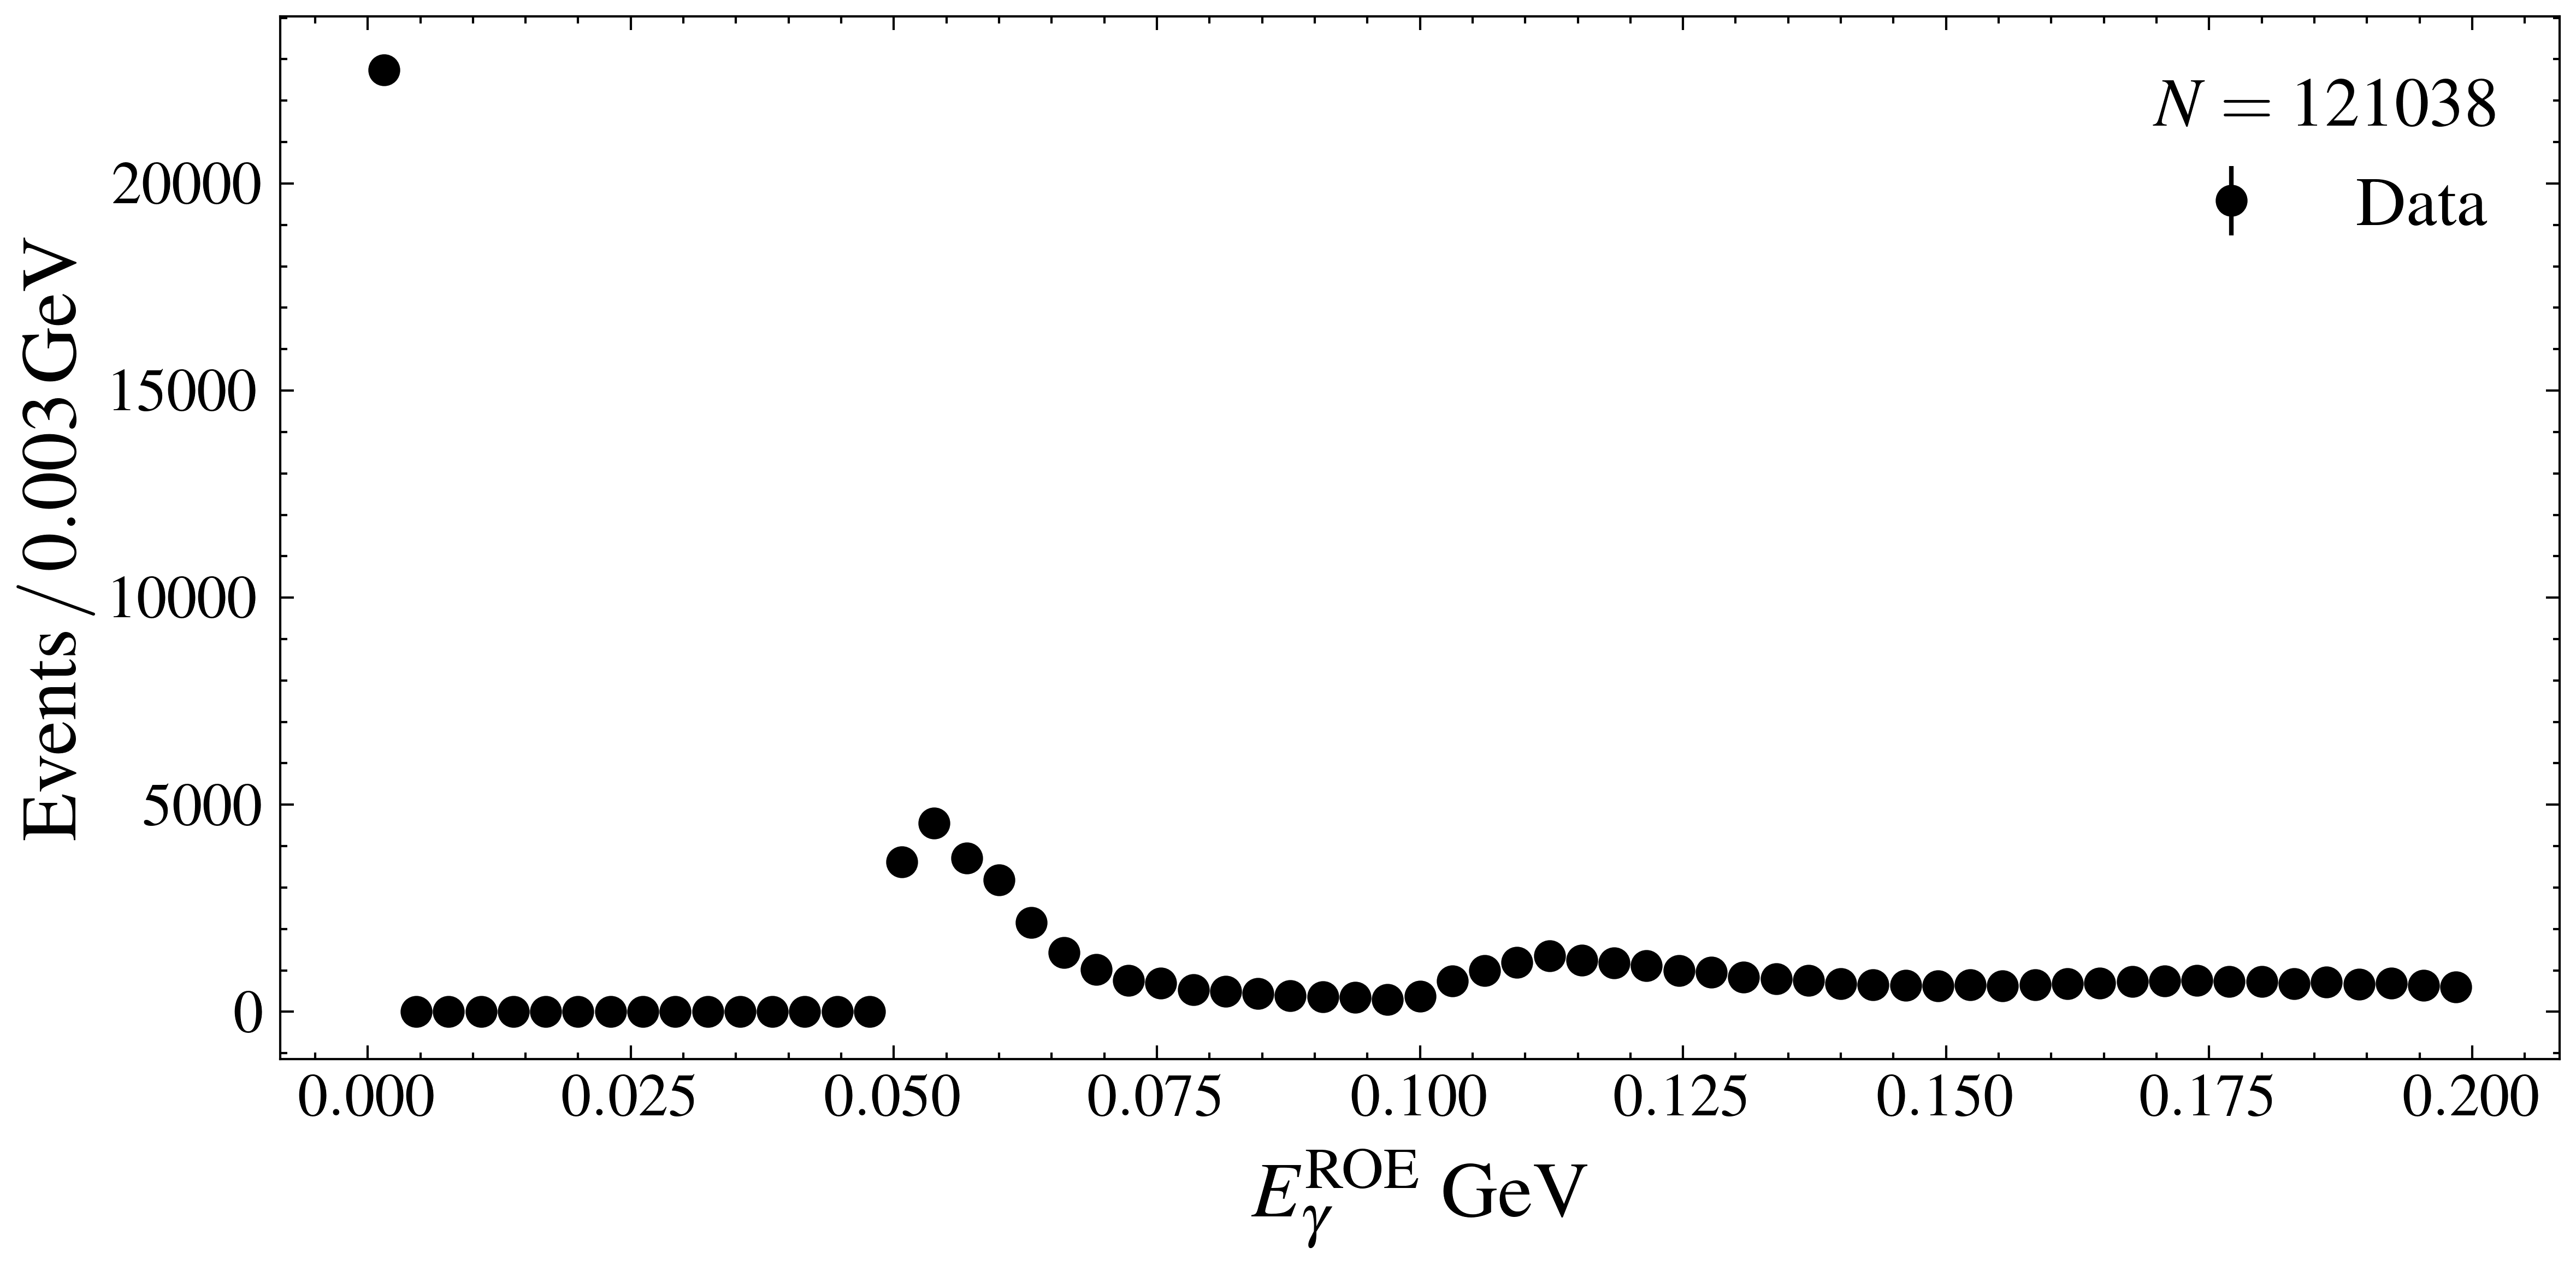

In [17]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_is0 & mask_is1 & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [20]:
E_g_lep = get_values(dataset, ["E_gamma_in_ROE", ], filter_mask= mask & mask_is0 & mask_is1 & mask_lep)

Total data size: 0.69 MB


In [ ]:
@njit(fastmath=True)
def exp_dis(x, lam, a=0, b=0):
    if a == b:
        normalization_factor = 1
    else:
        normalization_factor = lam / (np.exp(lam * (b)) - np.exp(lam * (a)))
    return normalization_factor * np.exp(lam * x)


In [ ]:
def f_E_g_lep(x, mu, lam):
    x = x - mu
    a = np.min(x)
    b = np.max(x)
    normalization_factor = lam / (np.exp(lam * (b)) - np.exp(lam * (a)))
    return normalization_factor * np.exp(lam * x)


In [ ]:
max_bin_lik

In [30]:
print(E_g_lep[(E_g_lep.E_gamma_in_ROE < 0.001)].shape[0])
print(E_g_lep[(E_g_lep.E_gamma_in_ROE < 0.049) & (E_g_lep.E_gamma_in_ROE > 0.001)].shape[0])
print(E_g_lep[(E_g_lep.E_gamma_in_ROE > 0.049)].shape[0])

22739
0
98299
